In [122]:
import cv2
import time
import numpy as np
from scipy.sparse.linalg import lsqr
from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os

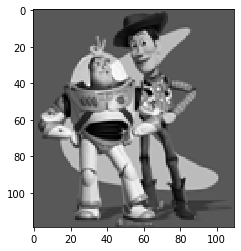

In [2]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2RGB)
toy_img = cv2.cvtColor(toy_img, cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")

## Part 1 Toy Problem (20 pts)

In [67]:
def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im=toy_img
    im_h, im_w = toy_img.shape
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    num_v = (im_h)*(im_w)
    num_e = im_h*(im_w-1) + im_w*(im_h-1) + 1
    A = np.zeros((num_e,num_v))
    b = np.zeros((num_e,))
    e=0
    for x in range(im_w):
        for y in range(im_h):
            if x < im_w-1:
                A[e][im2var[y][x+1]] = 1
                A[e][im2var[y][x]] = -1
                b[e] = im[y][x+1] - im[y][x]
                e+=1
            if y < im_h-1:
                A[e][im2var[y+1][x]] = 1
                A[e][im2var[y][x]] = -1
                b[e] = im[y+1][x] - im[y][x]
                e+=1
            
    A[e][im2var[0][0]] = 1
    b[e] = im[0][0]
    
    v = lsqr(A, b)
    
    return v[0].reshape((im_w, im_h)).T
            

Error is:  0.00031701850068623744


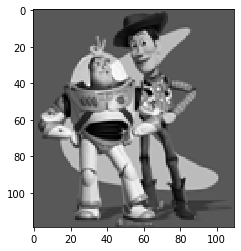

In [70]:
im_out = toy_reconstruct(toy_img)

if im_out.any():
    print("Error is: ", np.sqrt(((im_out - toy_img)**2).sum()))

plt.close()
plt.imshow(im_out, cmap="gray")

## Preparation

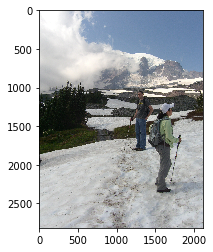

In [71]:
# Feel free to change image
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


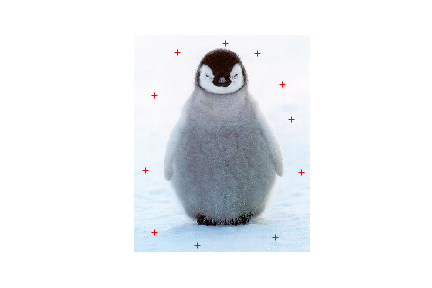

In [145]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

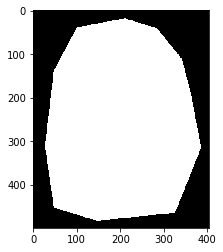

In [146]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


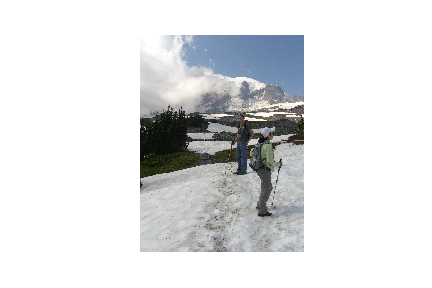

In [77]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

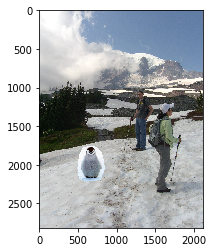

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)

(2816, 2112, 3)
(2816, 2112, 3)
134296
(134296, 3)
[[  1752    675      0]
 [  1752    676      1]
 [  1752    677      2]
 ...
 [  2215    620 134293]
 [  2215    621 134294]
 [  2215    622 134295]]


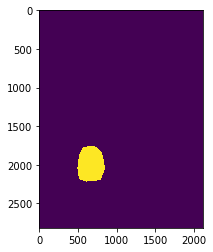

In [148]:
print(background_img.shape)
print(cropped_object.shape)
plt.figure()
plt.imshow(object_mask)
idx = np.where(object_mask==1)
print(idx[0].shape[0])
idx = np.concatenate((idx[0].reshape(-1,1),idx[1].reshape(-1,1),np.arange(idx[0].shape[0]).reshape(-1,1)),axis=1)
print(idx.shape)
print(idx)

## Part 2 Poisson Blending (50 pts)

In [150]:
A = csr_matrix((3,3))
A[0,0]=1
A[1,1]=2
b = csr_matrix((1,3))
b[0,0]=1
b[0,1]=1



print(f'A.shape {A.shape}')
print(f'b.shape {b.shape}')
v = lsqr(A, b)
        
        

A.shape (3, 3)
b.shape (1, 3)


ValueError: dimension mismatch

In [151]:
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    #TO DO 
    #idx is the list of x, y coordinates that are in the mask
    idx = np.where(object_mask==1)
    idx = np.concatenate((idx[0].reshape(-1,1),idx[1].reshape(-1,1)),axis=1)

    s=cropped_object
    t=background_img
    
    im_h, im_w, _ = t.shape
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    num_v = im_h*im_w
    num_e = np.where(object_mask==1)[0].shape[0] * 5
    return_v = np.zeros(t.shape)
    
    for c in range(3):
        A = csr_matrix((num_e,num_v))
        b = np.zeros((num_e,))
        e=0
        for x in range(im_w):
            for y in range(im_h):
                if object_mask[y][x]==1:
                    if x < im_w-1:
                        A[e,im2var[y][x+1]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = s[y][x][c] - s[y][x+1][c]
                        e+=1
                    if y < im_h-1:
                        A[e,im2var[y+1][x]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = s[y][x][c] - s[y+1][x][c]
                        e+=1
                    if x > 0:
                        A[e,im2var[y][x-1]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = s[y][x][c] - s[y][x-1][c]
                        e+=1
                    if y > 0:
                        A[e,im2var[y-1][x]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = s[y][x][c] - s[y-1][x][c]
                        e+=1
                    if object_mask[y][x+1]==0:
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y][x+1][c] + s[y][x][c] - s[y][x+1][c]
                        e+=1
                    if object_mask[y][x-1]==0:
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y][x-1][c] + s[y][x][c] - s[y][x-1][c]
                        e+=1
                    if object_mask[y+1][x]==0:
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y+1][x][c] + s[y][x][c] - s[y+1][x][c]
                        e+=1
                    if object_mask[y-1][x]==0:
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y-1][x][c] + s[y][x][c] - s[y-1][x][c]
                        e+=1
        print('starting segmenting')              
        A=A[:e,:]
        b=b[:e]
        print(f'A.shape {A.shape}')
        print(f'b.shape {b.shape}')
        v = lsqr(A, b)
        return_v[:,:,c] = v[0].reshape((im_w, im_h)).T
    
    d3_mask = np.stack((object_mask,object_mask,object_mask),axis=2)
    return_v = background_img*(1-d3_mask) + return_v*d3_mask

    return return_v

starting segmenting
A.shape (538830, 5947392)
b.shape (538830,)
starting segmenting
A.shape (538830, 5947392)
b.shape (538830,)
starting segmenting
A.shape (538830, 5947392)
b.shape (538830,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elapsed Time: 24198.081203460693


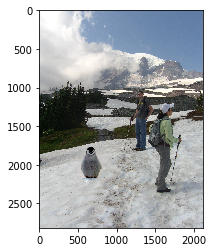

In [152]:
t = time.time()
im_blend = poisson_blend(cropped_object, object_mask, background_img)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend)
elapsed = time.time() - t

print(f'Elapsed Time: {elapsed}')

In [163]:
print(np.max(im_blend))
im_blend_sv = im_blend
im_blend_sv[im_blend_sv > 1] = 1.
im_blend_sv[im_blend_sv < 0] = 0.
#im_blend_sv = im_blend_sv / np.max(im_blend_sv)
plt.imsave('poisson_penguin.jpg',im_blend_sv)

1.5596327629807014


## Part 3 Mixed Gradients (20 pts)

In [15]:
def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    #TO DO 
    pass

In [16]:
im_mix = mix_blend(cropped_object, object_mask, background_img)
if im_mix.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [17]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [18]:
def laplacian_blend(img1, img2):
    pass

## More gradient domain processing (up to 20 pts)